<a href="https://colab.research.google.com/github/SarthakPradhan/Kaggle/blob/main/news_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:



test=pd.read_excel(r'/content/gdrive/MyDrive/KaggleDatasets/Participants_Data_News_category/Data_Test.xlsx')
df=pd.read_excel(r'/content/gdrive/MyDrive/KaggleDatasets/Participants_Data_News_category/Data_Train.xlsx')


print("df",df.shape)
print(df.columns)


df (7628, 2)
Index(['STORY', 'SECTION'], dtype='object')


In [4]:
df.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [5]:

missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)


In [6]:
missing

Series([], dtype: int64)

No Missing Values

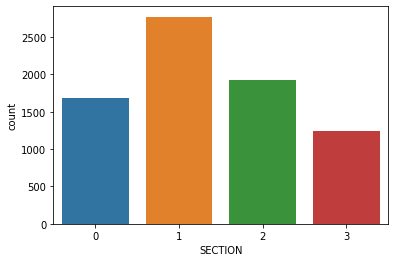

In [7]:
sns.countplot(x='SECTION',data=df)

In [8]:
# remove stopwords
nltk.download('stopwords')

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df["STORY"] = df.STORY.map(remove_stopwords)

In [10]:
df.head(15)

,STORY,SECTION
0,"painful huge reversal fee income, unheard amon...",3
1,"formidable opposition alliance among congress,...",0
2,asian currencies trading lower today. south ko...,3
3,"want answer question, click ‘answer’. clicking...",1
4,"global markets, gold prices edged today disapp...",3
5,beijing: chinese tech giant huawei announced p...,1
6,mumbai: india inc's external commercial borrow...,3
7,"wednesday, federal reserve chairman jerome pow...",3
8,give audience? already done yeh hai aashiqui p...,2
9,"com, arbaaz khan spoke getting back dabangg sa...",2


In [11]:

X_train = df['STORY']
y_train = df['SECTION']


In [12]:


X_train = X_train.to_numpy()
y_train = y_train.to_numpy()



In [13]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train = onehot_encoder.fit_transform(y_train)


In [14]:


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

for text,label in train_dataset.take(1):
    print('Text: ', text.numpy())
    print('Label: ', label.numpy())



Text:  b'painful huge reversal fee income, unheard among private sector lenders. essentially, means yes bank took granted fees structured loan deals paid accounted upfront books. borrowers turned defaulters, fees tied loan deals fell cracks. gill vowed shift safer accounting practice amortizing fee income rather booking upfront. gill\xe2\x80\x99s move mend past ways means nasty surprises future. good news considering investors love clean image loathe uncertainties. gain without pain promise strong stable balance sheet comes sacrifices well. investors give hopes phenomenal growth, promise made kapoor.'
Label:  [0. 0. 0. 1.]


In [15]:
BUFFER_SIZE = 4000
BATCH_SIZE = 64

In [16]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

BERT(pretrained)

In [ ]:
pip install tensorflow-text

In [ ]:
pip install tf-models-official

In [19]:
import tensorflow_text as text
from official.nlp import optimization

In [20]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

#Note: You can get these bert model and tfhub details on the tensorflow classify text with BERT page

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [29]:


def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(4, activation=tf.keras.activations.softmax, name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [30]:
text_test = ['Bruh this is such an amazing movie!']


In [31]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print((bert_raw_result))


tf.Tensor([[0.04145605 0.5138641  0.22333068 0.22134918]], shape=(1, 4), dtype=float32)


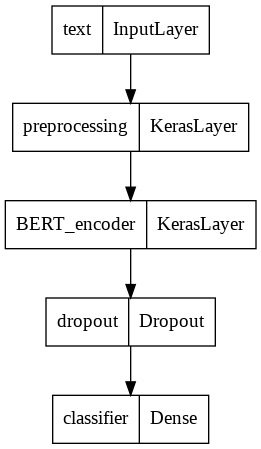

In [24]:
tf.keras.utils.plot_model(classifier_model)


In [33]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [37]:
classifier_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                         metrics=['accuracy'])


In [27]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 4)), types: (tf.string, tf.float64)>

In [38]:
bert_history = classifier_model.fit(train_dataset, epochs=epochs)


Epoch 1/2
120/120 [==============================] - 1830s 15s/step - loss: 0.3248 - accuracy: 0.8815
Epoch 2/2
120/120 [==============================] - 1822s 15s/step - loss: 0.0757 - accuracy: 0.9755


In [39]:
test

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...
2,It can be confusing to pick the right smartpho...
3,The mobile application is integrated with a da...
4,We have rounded up some of the gadgets that sh...
...,...
2743,"According to researchers, fraud in the mobile ..."
2744,The iPhone XS and XS Max share the Apple A12 c...
2745,"On the photography front, the Note 5 Pro featu..."
2746,UDAY mandated that discoms bring the gap betwe...


In [41]:
test["STORY"] = test.STORY.map(remove_stopwords)

In [42]:
X_test = test['STORY']
X_test_array = X_test.to_numpy()

In [43]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_array))

In [44]:
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [47]:


y_pred = classifier_model.predict(test_dataset)



In [55]:
y_pred

array([[1],
       [2],
       [1],
       ...,
       [1],
       [3],
       [1]])

In [51]:
y_pred.shape

(2748, 4)

In [54]:
#y_train = y_train.reshape(len(y_train), 1)
y_pred = onehot_encoder.inverse_transform(y_pred)

In [56]:
y_pred = y_pred.reshape(-1)

In [57]:
y_pred = np.round_(y_pred). astype(int)

In [58]:
y_pred

array([1, 2, 1, ..., 1, 3, 1])

In [53]:
ids=[i for i in range(2748)]

In [60]:
output = pd.DataFrame({ 'SECTION': y_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
